In [1]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt

# PyTorch imports
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# torchvision imports for datasets and transforms
from torchvision import datasets, transforms

In [2]:
# Define the CNN model
class MyCNN(nn.Module):
    """
    Simple CNN model with 2 convolutional layers and 2 fully connected layers.

    Args:
    -----
        nn.Module: Base class for all neural network modules in PyTorch.
    """
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Linear(128, 10)

        self._initialize_weights()

    def forward(self, x):
        """
        Forward pass of the model.
        
        Args:
        -----
            x (torch.Tensor): Input tensor.
        
        Returns:
        --------
            torch.Tensor: Output tensor.
        """
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    # Xavier weight initialization
    def _initialize_weights(self):
        """
        Initialize the weights of the model.
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [3]:
class EarlyStopping:
    """
    Early stopping to stop the training when the loss does not improve after

    Args:
    -----
        patience (int): Number of epochs to wait before stopping the training.
        verbose (bool): If True, prints a message for each epoch where the loss
                        does not improve.
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
    """
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [4]:
class Trainer:
    """
    Trainer class to train the model.

    Args:
    -----
        model (nn.Module): Neural network model.
        criterion (torch.nn.modules.loss): Loss function.
        optimizer (torch.optim): Optimizer.
        device (torch.device): Device to run the model on.
        patience (int): Number of epochs to wait before stopping the training.
    """
    def __init__(self, model, criterion, optimizer, device, patience=7):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.early_stopping = EarlyStopping(patience=patience)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', patience=3, verbose=True, factor=0.5, min_lr=1e-6)
        self.train_losses = []
        self.val_losses = []
        self.gradient_norms = []

    def train(self, train_loader, val_loader, epochs):
        """
        Train the model.
        
        Args:
        -----
            train_loader (torch.utils.data.DataLoader): DataLoader for training dataset.
            val_loader (torch.utils.data.DataLoader): DataLoader for validation dataset.
            epochs (int): Number of epochs to train the model.
        """
        for epoch in range(epochs):
            self.model.train()
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
            
            self.train_losses.append(loss.item())

            val_loss = self.evaluate(val_loader)
            self.val_losses.append(val_loss)
            self.scheduler.step(val_loss)
            self.early_stopping(val_loss)

            # Log the training and validation loss
            print(f'Epoch {epoch+1}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

            if self.early_stopping.early_stop:
                print("Early stopping")
                break

    def evaluate(self, test_loader):
        """
        Evaluate the model on the test dataset.

        Args:
        -----
            test_loader (torch.utils.data.DataLoader): DataLoader for test dataset.

        Returns:
        --------
            float: Average loss on the test dataset.
        """
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()

        return total_loss / len(test_loader)
    
    def accuracy(self, test_loader):
        """
        Calculate the accuracy of the model on the test dataset.

        Args:
        -----
            test_loader (torch.utils.data.DataLoader): DataLoader for test dataset.

        Returns:
        --------
            float: Accuracy of the model on the test dataset.
        """
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        return correct / total

    def plot_losses(self, window_size=100):
        # Compute moving averages
        train_losses_smooth = self.moving_average(self.train_losses, window_size)
        val_losses_smooth = self.moving_average(self.val_losses, window_size)

        # Plot
        plt.plot(train_losses_smooth, label='Train Loss')
        plt.plot(val_losses_smooth, label='Validation Loss')
        plt.legend()
        plt.grid()
        plt.title('Losses')

    def moving_average(self, data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

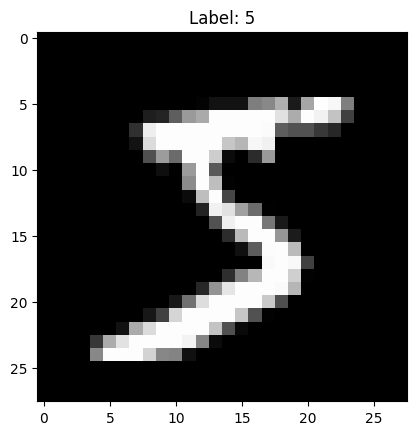

In [5]:
# Data loading and transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize for grayscale image
])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Plot a sample image
image, label = mnist_dataset[0]
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title(f'Label: {label}')
plt.show()

In [6]:
# Split the dataset into training and validation sets
train_split = 0.8

train_size = int(train_split * len(mnist_dataset))
val_size = len(mnist_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(mnist_dataset, [train_size, val_size])

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
# Model instantiation
model = MyCNN()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5, amsgrad=True, eps=1e-8,  betas=(0.9, 0.999))

# Trainer instantiation
trainer = Trainer(model, criterion, optimizer, device, patience=10)

# Training
trainer.train(train_loader, val_loader, epochs=100)

# Evaluation
loss = trainer.evaluate(test_loader)
accuracy = trainer.accuracy(test_loader)
print(f'Accuracy: {accuracy:.2%}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Training Loss: 0.1202, Validation Loss: 0.2131
Epoch 2, Training Loss: 0.0789, Validation Loss: 0.1391
Epoch 3, Training Loss: 0.1775, Validation Loss: 0.1021
Epoch 4, Training Loss: 0.0281, Validation Loss: 0.0922
Epoch 5, Training Loss: 0.0653, Validation Loss: 0.0717
Epoch 6, Training Loss: 0.1352, Validation Loss: 0.0698
Epoch 7, Training Loss: 0.0422, Validation Loss: 0.0648
Epoch 8, Training Loss: 0.0083, Validation Loss: 0.0648
Epoch 9, Training Loss: 0.0361, Validation Loss: 0.0579
Epoch 10, Training Loss: 0.0227, Validation Loss: 0.0542
Epoch 11, Training Loss: 0.0589, Validation Loss: 0.0543
Epoch 12, Training Loss: 0.0146, Validation Loss: 0.0580
Epoch 13, Training Loss: 0.0766, Validation Loss: 0.0564
Epoch 14, Training Loss: 0.0035, Validation Loss: 0.0544
Epoch 15, Training Loss: 0.0762, Validation Loss: 0.0479
Epoch 16, Training Loss: 0.0185, Validation Loss: 0.0491
Epoch 17, Training Loss: 0.0059, Validation Loss: 0.0506
Epoch 18, Training Loss: 0.0066, Validat

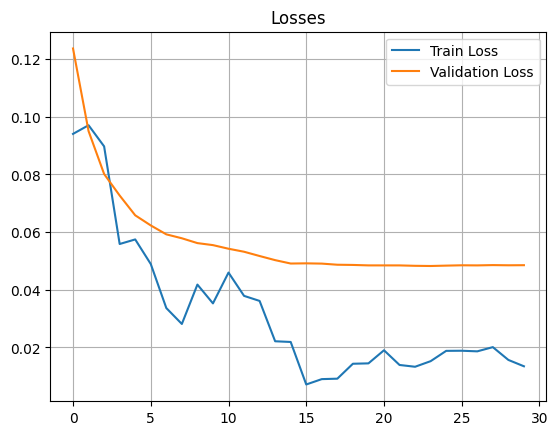

In [9]:
trainer.plot_losses(5)